In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

1.1

Implementing the functions to represent the system:

In [2]:
def g(t,delta_t, g_old):
    a=1/(np.sqrt(delta_t))
    g_new=np.array([-1.99999*g_old[0]+a/2,-1.99999*g_old[1]+a/2,-1.99999*g_old[2]+a/2])
    for i in range(0,len(g_old)):
        if(g_old[i]<0 and g_old[i]>=-a/2):
            g_new[i]=1.99999*g_old[i]+a/2
    return g_new
def f(z, g_old): 
    sigma=10
    rho=28
    beta=8/3
    val=np.array([sigma*(z[1]-z[0]) + g_old[0],z[0]*(rho-z[2])-z[1] + g_old[1],z[0]*z[1]-beta*z[2] + g_old[2]])
    return val
def forward_euler(z_0,g_0, N=int(200/0.001),delta_t=0.001, fun=f): #N is the number of intervals: N=30/delta_t
    """Function that implements Forward Euler Method, z_0 is the initial condition, delta_t is the size of the N time intervals needed for discretization"""
    time=np.zeros((N+1,))
    z_tilde=np.zeros((3,N+1))
    z_tilde[:,0]=z_0
    g_old=g_0
    for k in range(0,N):
        z_tilde[:,k+1]=z_tilde[:,k]+delta_t*fun(z_tilde[:,k], g_old)
        time[k+1]=time[k]+delta_t
        g_old=g(time[k+1],delta_t,g_old)
        
    return z_tilde

The Lorenz system is described by the following ODE: <br>
$\dot{z}(t)=f(z)+g(t)$, where $g$ and $f$ are defined as above and $z=(x,y,z)^T\in\mathbb{R}^3$.  <br> 
As surrogate model ($z_{ref}$) we consider the numerical approximation of this ODE that we obtain by Euler method with $\delta t=0.001$ and $N=\frac{200}{\delta t}=200000$ iterations: <br>
$\begin{cases}z_0=(-0.587,-0.563,16.870)^T \\ z_{n+1}=z_n+\delta t (f(z_n)+g(t_n)) \\ t_{n+1}=t_n+\delta t\end{cases}$. <br>
Finally, for what concerns $g(t_n)$, the tent map, we implement it in a way that allows to reduce errors caused by floating point arithmetic. 

In [3]:
z_0=[-0.587,-0.563,16.870]
a=1/np.sqrt(0.05)
g_0=np.array([a*(1/np.sqrt(2)-1/2),a*(1/np.sqrt(3)-1/2),a*(1/np.sqrt(5)-1/2)])
z_tilde=forward_euler(z_0,g_0)

Plotting the result:

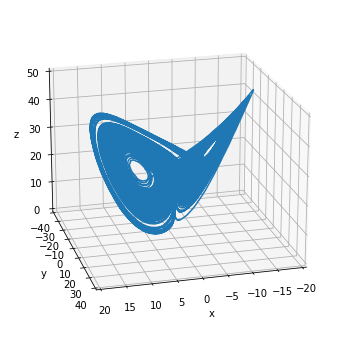

In [4]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
ax.plot(z_tilde[0,:],z_tilde[1,:], z_tilde[2,:])
ax.set_zlim(0,50)
ax.set_xlim(-20,20)
ax.set_ylim(-40,40)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(20, 75)

Storing the results with $\delta t_{out}=0.05$:

In [5]:
z_tilde_out=[]
deltat_out=0.05
delta_t=0.001
for k in range(0,z_tilde.shape[1],50):
            z_tilde_out.append(z_tilde[:,k])
ref_trajectory_array=np.array(z_tilde_out) #to be used in 1.2

In [6]:
ref_trajectory=pd.DataFrame(z_tilde_out).transpose()
print(ref_trajectory.shape)
ref_trajectory.to_csv("Reference_trajectory_0.05.csv",index=False, header=False)

(3, 4001)


1.2

We have saved the reference trajectory using $\delta t_{out}=0.05$, since we want the frequency of the observations to be smaller (i.e measurement frequency is smaller than the one used to produce the surrogate model ($z_{ref}$)): we get an observation every $\delta t_{out}$. <br> 
We get observations this way:
$y_{obs}(t)=h(z_{ref}(t))+ \sum_{i=0}^I \eta_i(t)$, where the $\eta_is$ represent the measurement errors. In this exercise we observe only the $x$- component, then we have $h(z_{ref}(t))=<(1,0,0),z_{ref}(t)>=x_{ref}(t)$. 
Furthermore to generate the measurement errors we use a different implementation of the tent map (different $a$) with respect to the previous one.
In this exercise we generate $N_{obs}=4000$ observations (up to time 200).


In [7]:
#tent maps for observations (different recursions): 
def csi_1(k):
    """Tent map function with *2"""
    csi_old=0
    csi=list(np.zeros((k,)))
    csi[0]=4*(1/np.sqrt(2)-1/2)
    for i in range(0,k-1):
        csi_old=csi[i]
        if(csi_old<0 and csi_old>=-2): #a/2=4/2=2
            csi[i+1]=2*(csi_old+1) #4/2=2
        else:
            csi[i+1]=-2*(csi_old-1)
    return csi 
def csi_2(k):
    """Tent map function with *1.99999"""
    a=4
    csi=list(np.zeros((k,)))
    csi[0]=4*(1/np.sqrt(2)-1/2)
    for i in range(0,k-1):
        csi_old=csi[i]
        if(csi_old<0 and csi_old>=-2): #a/2=4/2=2
            csi[i+1]=1.99999*csi_old+a/2
        else:
            csi[i+1]=-1.99999*csi_old+a/2
    return csi

def measurement_error(Nobs, tent_map_type):
    """Function to generate measurement errors using the tent map"""
    Csi=np.zeros((20*Nobs+1,)) #for each observations we consider 20 components of Csi.
    if(tent_map_type==2):
        csi=csi_2(200*Nobs+1) #tent map
    else:
        csi=csi_1(200*Nobs+1)
    for i in range(1,Csi.shape[0]):
        Csi[i]=csi[10*i]
    return Csi

def generate_observations(ref_trajectory, tent_map_type): 
    """Function to generate observations with measurement errors implemented above. 
       I assume that we want to generate observations for the first component, as required in the exercise.
       If tent_map_type==1 csi_1 is called, otherwise csi_2 is called"""
    N_obs=len(ref_trajectory)
    x_obs=np.zeros((N_obs,))
    measurement_errors=np.zeros((N_obs,))
    if(tent_map_type==2):
        Csi=measurement_error(N_obs,2)
    else:
        Csi=measurement_error(N_obs,1)
    x_obs[0]=ref_trajectory[0]
    for k in range(1,N_obs):
        if(k==1):
            ind1=1
        else:
            ind1=ind2
        ind2=ind1+20
        measurement_errors[k]=1/20*sum(Csi[ind1:ind2])
        x_obs[k]=ref_trajectory[k]+ measurement_errors[k]
    return x_obs, measurement_errors



Generating observations with the two different recursions for the tent map:

In [8]:
x_obs_1, m_errors1=generate_observations(ref_trajectory_array[:,0],1) #first version of the tent map
x_obs_2, m_errors2=generate_observations(ref_trajectory_array[:,0],2) #second version of the tent map

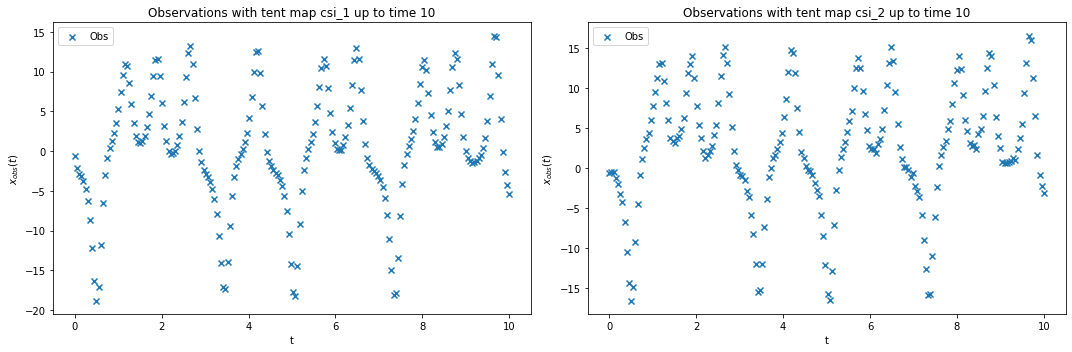

In [9]:
x=np.linspace(0,10,200)
time=10
fig,ax=plt.subplots(1,2, figsize=(15,5))
ax[0].scatter(x,x_obs_1[:int(time/deltat_out)], marker='x', label='Obs')
ax[0].legend(loc='best')
ax[0].set_xlabel('t')
ax[0].set_ylabel('$x_{obs}(t)$')
ax[0].set_title('Observations with tent map csi_1 up to time 10')
ax[1].scatter(x,x_obs_2[:int(time/deltat_out)], marker='x', label='Obs')
ax[1].legend(loc='best')
ax[1].set_xlabel('t')
ax[1].set_ylabel('$x_{obs}(t)$')
ax[1].set_title('Observations with tent map csi_2 up to time 10')
fig.tight_layout()
#we see that there is a slight difference

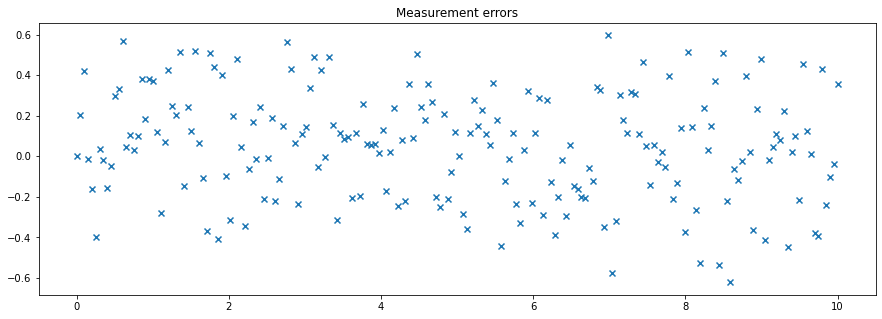

In [15]:
plt.figure(figsize=(15,5))
plt.scatter(x,m_errors2[:int(time/deltat_out)], marker='x')
plt.title("Measurement errors");

1.3 Making predictions. We set $t_{k_*}=100$ and make 2000 predictions until time $t=200$, which means that we start from $k=2000$ and stop at $k=4000$

For linear extrapolation we just need the two observations before the one we want to predict

If we are at time $t_{k_*}$ and we want to predict $x_{obs}(t_{k_*+1})$ we can fit a polynomial of degree 1 (i.e a line) passing through $x_{obs}(t_{k_*-1})$ and $x_{obs}(t_{k_*})$, which then is:<br>
$p(t)=x_{obs}(t_{k_*-1})+(t-t_{k_*})\frac{x_{obs}(t_{k_*})-x_{obs}(t_{k_*-1})}{\delta t_{out}}$, <br>
then since $\delta t_{out}=x_{obs}(t_{k_*})-x_{obs}(t_{k_*-1})=x_{obs}(t_{k_*+1})-x_{obs}(t_{k_*})$, we get the linear extrapolation formula: <br>
$x_p(t_{k_*+1})=p(t_{k_*+1})=2x_{obs}(t_{k_*})-x_{obs}(t_{k_*-1})$

We use $x_{obs2}$

In [12]:
def squared_absolute_error(x_ob,x_pred):
    return abs(x_ob-x_pred)**2
def make_prediction(x_ob1,x_ob2):
    return 2*x_ob2-x_ob1
def rmse(abs_errors):
    return np.sqrt(abs_errors.mean())

abs_errors=np.zeros((2000,))
predictions=np.zeros((2000,))
for i in range(2001,4001):
    predictions[i-2001]=make_prediction(x_obs_2[i-2],x_obs_2[i-1])
    abs_errors[i-2001]=squared_absolute_error(x_obs_2[i],predictions[i-2001])
rmse=rmse(abs_errors)
print("Mean squared error: %r" %rmse)


Mean squared error: 1.3092317068172357


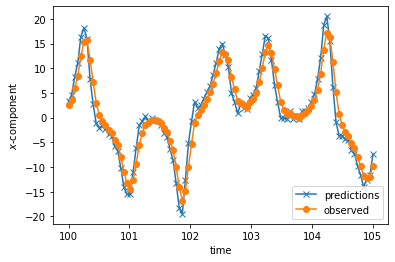

In [14]:
fig1,ax1=plt.subplots()
x1=np.linspace(100,105,100)
ax1.plot(x1,predictions[:100], label='predictions', marker='x')
ax1.plot(x1,x_obs_2[2000:2100], label='observed', marker='o')
ax1.legend(loc='best')
ax1.set_xlabel('time');
ax1.set_ylabel('$x$-component');